<a href="https://colab.research.google.com/github/min02yam/R-study/blob/main/20220522_hotel_%ED%95%98%EB%8A%94%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------------------------------
## 호텔 예약 취소 고객 예측하기

본 데이터는 호텔 예약과 관련된 데이터입니다. 호텔, 고객, 예약과 관련된 정보들이 있습니다. 

**AUC가 높은 모델**을 만드는 것이 목표입니다.

목표입니다.

### 1. 전처리

- 결측치가 있는 열을 찾아 최빈값으로 대체
- 연속형 변수 (numeric): normalization 실행 (scale, min-max scaling 등을 활용)
- 범주형 변수 (factor, character): label encoding 또는 one-hot encoding (dummy) 사용하여 전처리
    - label encoding: 문자형 변수를 숫자로 대체
    - one-hot encoding: 문자형 변수들을 0,1로 구성된 여러 개의 더미 변수들로 만들기
        - e.g. location (서울, 대전, 인천, 부산 ...) 변수 ⇒ location_서울, location_대전, location_인천 등
        - `fastDummies` 패키지 활용해보기

### 2. 모델링

- 원하는 모델을 사용하여 호텔 예약 취소 고객을 예측할 것
    - `set.seed(2022)` 사용
    - Train Test 비율: 7:3
    - Y: `is_canceled`
    - X: Y변수를 제외한 **모든 변수를 활용**
    - **예측 확률값**을 csv 파일로 제출하기
        - 모델링할 때 파라미터 또는 `predict( )` 사용 시 확률값 출력 가능
    - 가장 높은 AUC를 달성한 분께는 **스타벅스 기프티콘**


--------------------------------------------------------------------------


# 1. 데이터 로드 및 간단 구조 확인

In [11]:
#installed.packages()
#library(dplyr)
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [5]:
install.packages(c("DataExplorer","fastDummies"))
library(DataExplorer); library(fastDummies)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’, ‘htmlwidgets’, ‘igraph’, ‘reshape2’, ‘gridExtra’, ‘networkD3’




In [10]:
install.packages("tidyquant");   install.packages("tidyverse")
library(tidyquant); library(tidyverse)  

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘globals’, ‘later’, ‘listenv’, ‘parallelly’, ‘gower’, ‘hardhat’, ‘ipred’, ‘furrr’, ‘crosstalk’, ‘promises’, ‘warp’, ‘BH’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘RcppArmadillo’, ‘RcppRoll’, ‘future’, ‘quadprog’, ‘zoo’, ‘recipes’, ‘rsample’, ‘plotly’, ‘padr’, ‘slider’, ‘anytime’, ‘forecast’, ‘tsfeatures’, ‘snakecase’, ‘PerformanceAnalytics’, ‘quantmod’, ‘lazyeval’, ‘Quandl’, ‘riingo’, ‘alphavantager’, ‘timetk’, ‘timeDate’, ‘TTR’, ‘xts’, ‘janitor’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: lubridate

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading re

In [6]:
df<-read.csv("/content/hotel.csv")

In [7]:
str(df); summary(df)

'data.frame':	119390 obs. of  17 variables:
 $ hotel_type                    : chr  "Resort Hotel" "Resort Hotel" "Resort Hotel" "Resort Hotel" ...
 $ is_canceled                   : int  0 0 0 0 0 0 0 0 1 1 ...
 $ lead_time                     : int  342 737 7 13 14 14 0 9 85 75 ...
 $ stays_in_weekend_nights       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stays_in_week_nights          : int  0 0 1 1 2 2 2 2 3 3 ...
 $ adults                        : int  2 2 1 1 2 2 2 2 2 2 ...
 $ children                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ babies                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ meal                          : chr  "BB" "BB" "BB" "BB" ...
 $ is_repeated_guest             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ previous_cancellations        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ previous_bookings_not_canceled: int  0 0 0 0 0 0 0 0 0 0 ...
 $ reserved_room_type            : chr  "C" "C" "A" "A" ...
 $ assigned_room_type            : chr  "C" "C" "C" "A" ...
 $ booking_changes 

  hotel_type         is_canceled       lead_time   stays_in_weekend_nights
 Length:119390      Min.   :0.0000   Min.   :  0   Min.   : 0.0000        
 Class :character   1st Qu.:0.0000   1st Qu.: 18   1st Qu.: 0.0000        
 Mode  :character   Median :0.0000   Median : 69   Median : 1.0000        
                    Mean   :0.3704   Mean   :104   Mean   : 0.9276        
                    3rd Qu.:1.0000   3rd Qu.:160   3rd Qu.: 2.0000        
                    Max.   :1.0000   Max.   :737   Max.   :19.0000        
                                                                          
 stays_in_week_nights     adults          children           babies         
 Min.   : 0.0         Min.   : 0.000   Min.   : 0.0000   Min.   : 0.000000  
 1st Qu.: 1.0         1st Qu.: 2.000   1st Qu.: 0.0000   1st Qu.: 0.000000  
 Median : 2.0         Median : 2.000   Median : 0.0000   Median : 0.000000  
 Mean   : 2.5         Mean   : 1.856   Mean   : 0.1039   Mean   : 0.007949  
 3rd Qu.: 3.0  


1. 범주형 4, 연속형 12, 타겟1은 이진분류
2. 분포를 더 살펴 보아야 알겠지만, 변수 명세서를 봤을 때 어른의 수(adults), 취소되지 않은 예약 횟수, 호텔 평균 가격(adr) 등 포텐셜 아웃라이어로 예상되는 값이 존재한다<br> ⏩문제에 해당된 전처리만 한다면 아웃라이어에 민감하지 않은 모델을 선택해야 한다.
3. children에 NA 4개 존재
4. 스케일링 필요

# 2. Basic EDA

1) 인트로

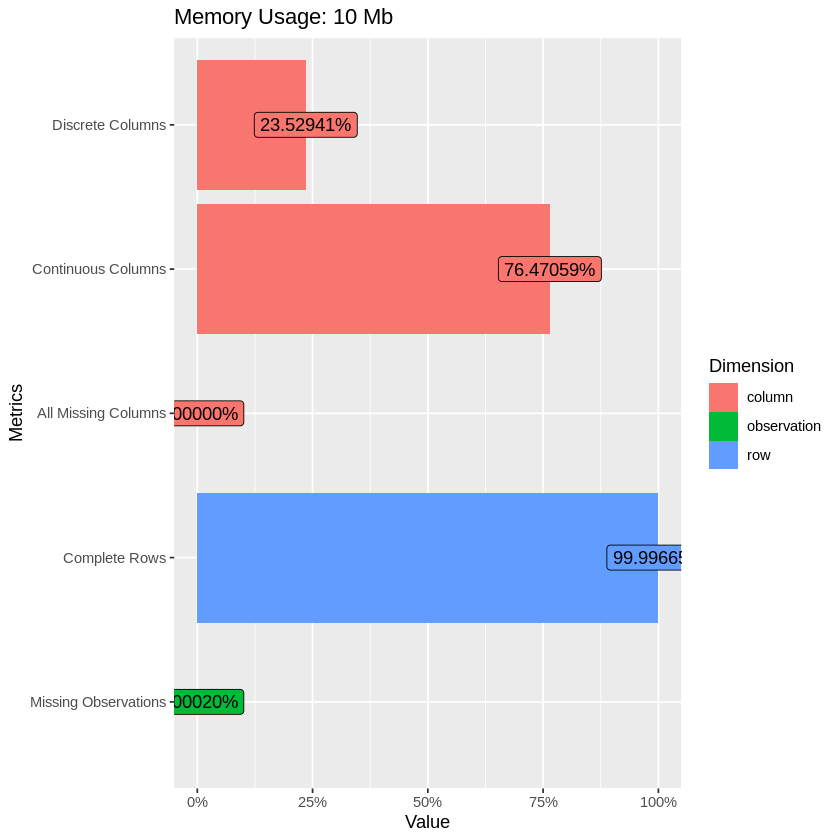

In [12]:
plot_intro(df)

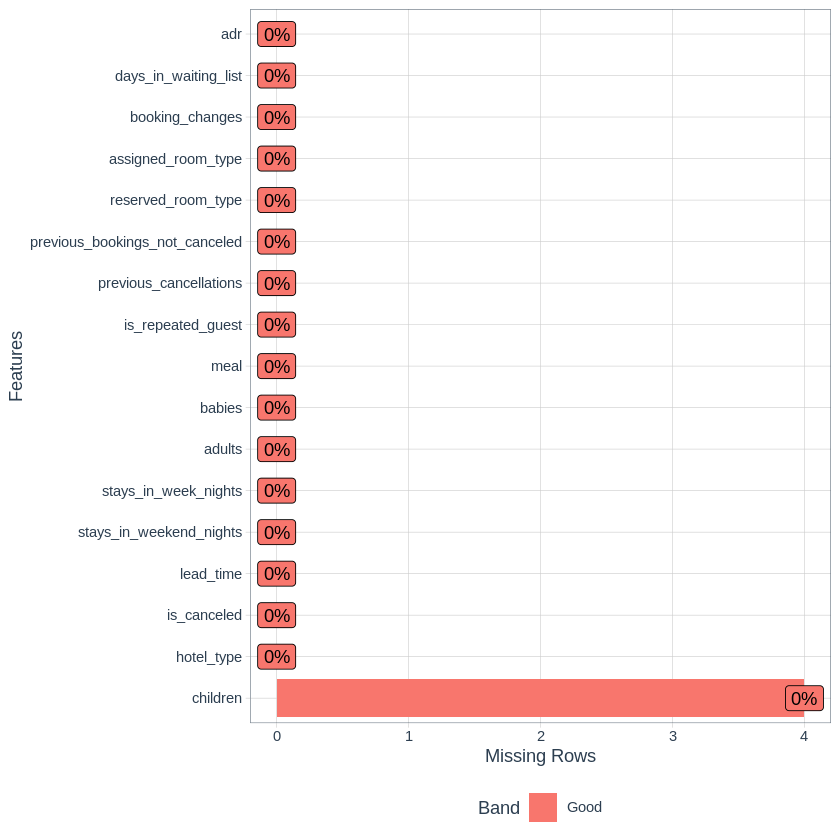

In [13]:
plot_missing(df, ggtheme = theme_tq())

* 앞서 확인한 것과 같음

In [20]:
library(magrittr) #파이프


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




범주형

In [21]:
  df %<>% mutate(is_canceled = as.factor(is_canceled)) 

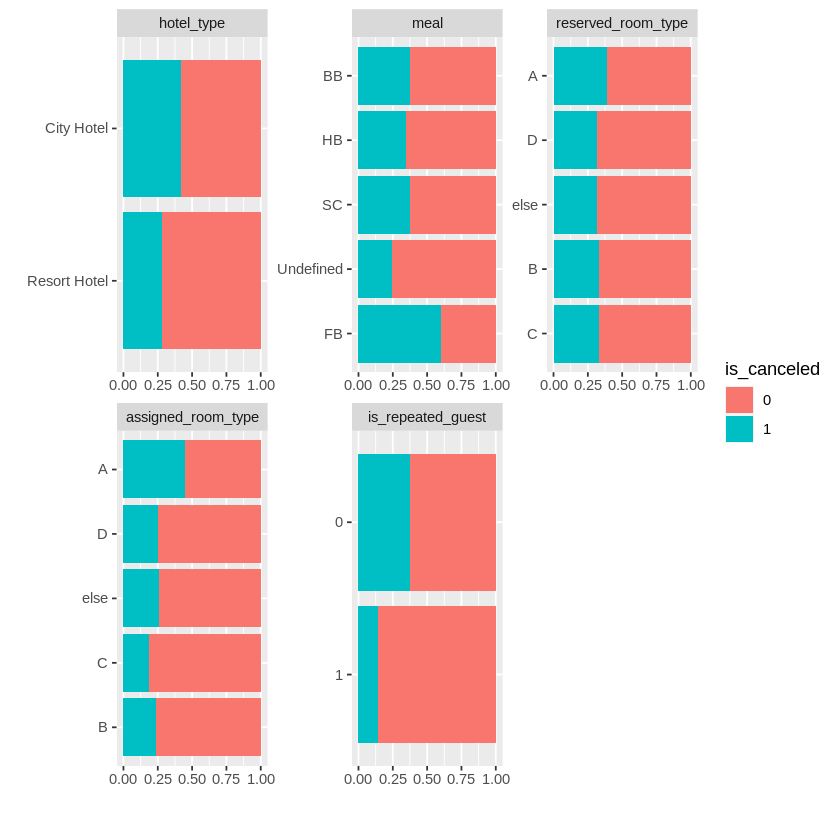

In [30]:
plot_bar(df, by ='is_canceled')   # 머지 원래 이렇헤 뜨면 안됨

In [ ]:
table

In [14]:
df_melt<-melt(df, id.vars ="is_canceled")

In [18]:
box(df_melt)

ERROR: ignored

# 3. 전처리

1) 임퓨테이션

2) 연속형피처

3) 범주형피처

#4. 모델링

1) 트레인 테스트 스플릿

In [ ]:
#set.seed(2022)